In [2]:
import torch
from utils import Normalise
from dataset import Simulation, FkDataset
import fk
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from sklearn.cluster import SpectralClustering, KMeans, MiniBatchKMeans
from utils import space_grad, space_grad_mse_loss
from unet3d import Unet3D
from resnet import ResNet
from glob import glob
import time

In [1]:
# filename = "/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/spiral_params5.hdf5"
root = "/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/"
model = ResNet.load_from_checkpoint(glob("lightning_logs/resnet/lightning_logs/version_80/checkpoints/*.ckpt")[0])
model.frames_out = 50
fkset = FkDataset(root, model.frames_in, model.frames_out, model.step, transform=Normalise(),
                  keys=["heartbeat_params3.hdf5"])
i = random.choice(range(len(fkset)))

y, w, u = fkset[i][0]

value = u

plt.figure(figsize=(10, 10))
im = plt.imshow(value)

TypeError: __init__() missing 4 required positional arguments: 'root', 'paramset', 'batch_size', and 'n_workers'

### Network prediction

torch.Size([1, 53, 3, 256, 256])
torch.Size([1, 3, 3, 256, 256])
torch.Size([1, 50, 3, 256, 256])
torch.Size([1, 50, 3, 256, 256])
Computation time: 1.3782072067260742ms
Input


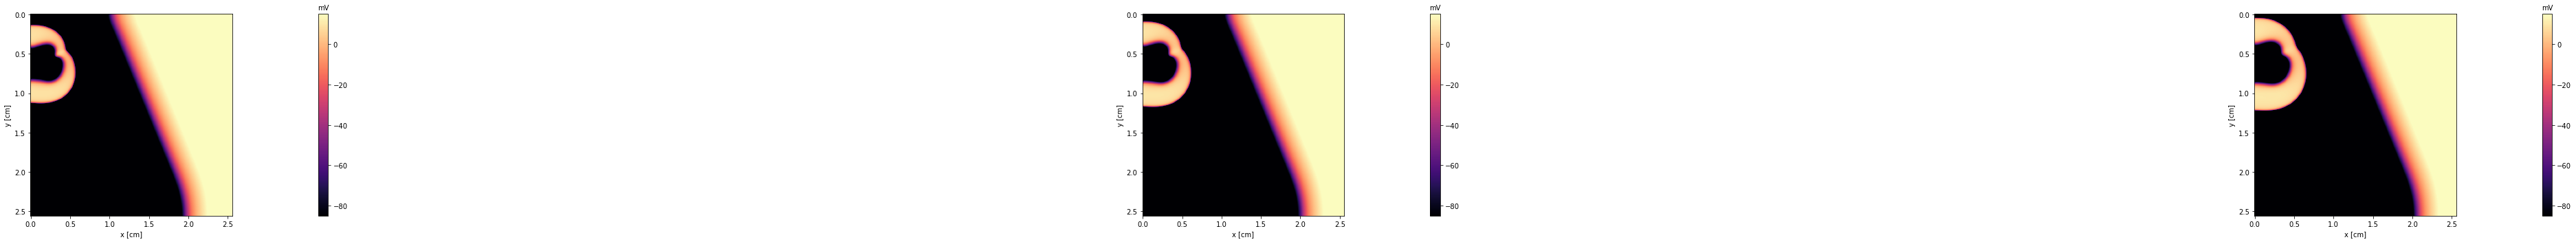

Prediction


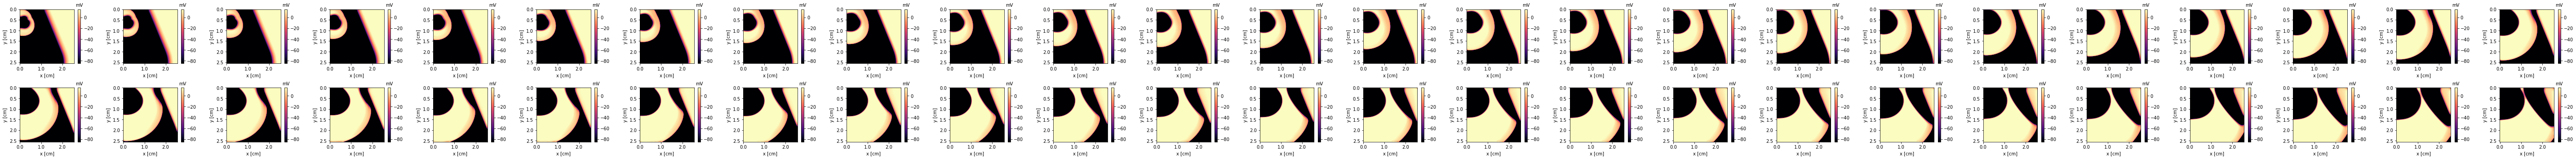

Truth


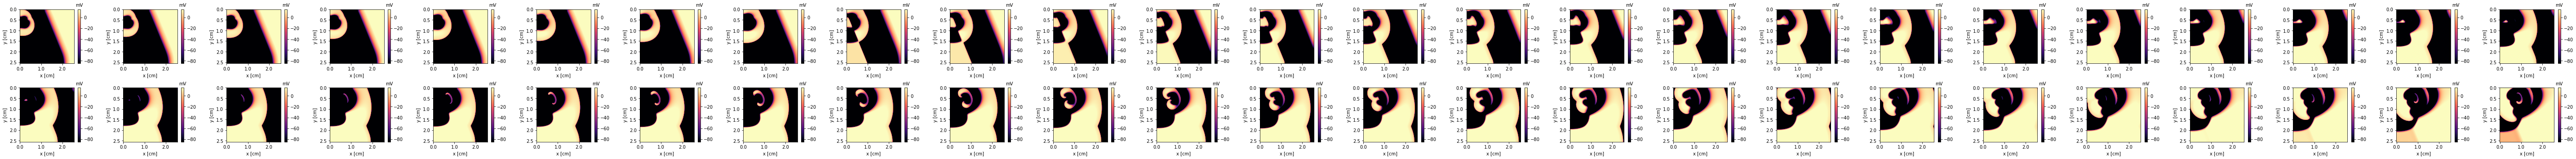

In [28]:
device = torch.device("cuda:1")
sequence = torch.as_tensor(fkset[random.randint(0, len(fkset) - 1)]).unsqueeze(0).to(device)
print(sequence.shape)
x = sequence[:, :model.frames_in]
y = sequence[:, model.frames_in:]
print(x.shape)
print(y.shape)
model = model.to(device)
start = time.time()
pred = model.validation_step(sequence, 1)
elapsed = time.time() - start
pred = pred["out"][1]
print(pred.shape)
print("Computation time: {}ms".format(elapsed))
print("Input")

rows = 25
figsize = (80, 5)
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(x[0, :, 2].detach().cpu()), rows=rows, figsize=figsize)
plt.show()
print("Prediction")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(pred[0, :, 2].detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)))
plt.show()
print("Truth")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(y[0, :, 2].detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)))

## Testing gradients

In [ ]:
dx, dy = space_grad(torch.as_tensor(value))
dxx, dxy = space_grad(torch.as_tensor(dx))
dyx, dyy = space_grad(torch.as_tensor(dy))

fig, ax = plt.subplots(3, 4, figsize=(15, 12))

ax[0, 0].set_title("dx")
im = ax[0, 0].imshow(dx, vmin=-1, vmax=1, cmap="RdBu")

ax[0, 1].set_title("dy")
im = ax[0, 1].imshow(dy, vmin=-1, vmax=1, cmap="RdBu")

ax[0, 2].set_title("dx + dy")
im = ax[0, 2].imshow(dx + dy, vmin=-1, vmax=1, cmap="RdBu")

ax[0, 3].set_title("torch.abs(dx) + torch.abs(dy)")
im = ax[0, 3].imshow(torch.abs(dx) + torch.abs(dy), vmin=-1, vmax=1, cmap="RdBu")


ax[1, 0].set_title("dxx")
im = ax[1, 0].imshow(dxx, vmin=-1, vmax=1, cmap="RdBu")

ax[1, 1].set_title("dxy")
im = ax[1, 1].imshow(dxy, vmin=-1, vmax=1, cmap="RdBu")

ax[1, 2].set_title("dxx + dxy")
im = ax[1, 2].imshow(dxx + dxy, vmin=-1, vmax=1, cmap="RdBu")

ax[1, 3].set_title("torch.abs(dxx) + torch.abs(dxy)")
im = ax[1, 3].imshow(torch.abs(dxx) + torch.abs(dxy), vmin=-1, vmax=1, cmap="RdBu")


ax[2, 0].set_title("dyx")
im = ax[2, 0].imshow(dyx, vmin=-1, vmax=1, cmap="RdBu")

ax[2, 1].set_title("dyy")
im = ax[2, 1].imshow(dyy, vmin=-1, vmax=1, cmap="RdBu")

ax[2, 2].set_title("dyx + dyy")
im = ax[2, 2].imshow(dyx + dyy, vmin=-1, vmax=1, cmap="RdBu")

ax[2, 3].set_title("torch.abs(dyx) + torch.abs(dyy)")
im = ax[2, 3].imshow(torch.abs(dyx) + torch.abs(dyy), vmin=-1, vmax=1, cmap="RdBu")

In [ ]:
a, b = pred[0, 0, 2], y[0, 0, 2]
ax, ay = space_grad(a)
bx, by = space_grad(b)
a_grad = torch.abs(ax) + torch.abs(ay)
b_grad = torch.abs(bx) + torch.abs(by)

grad = Normalise()((a_grad.detach() - b_grad.detach()).exp())
im = plt.imshow(grad, vmin=-1, vmax=1, cmap="RdBu")
plt.colorbar(im)

## Blob detection using clustering

In [ ]:
class KMeans:
    def __init__(self, n_clusters=10, n_iter=100):
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        self.labels_ = None
        self.cluster_centers_ = None
        
    def fit(self, x):
        N, D = x.shape  # Number of samples, dimension of the ambient space

        c = x[:self.n_clusters, :].clone()  # Simplistic random initialization
        x_i = torch.tensor(x[:, None, :])  # (Npoints, 1, D)

        for i in range(self.n_iter):

            c_j = torch.tensor(c[None, :, :])  # (1, Nclusters, D)
            D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
            cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

            Ncl = torch.bincount(cl)  # Class weights
            for d in range(D):  # Compute the cluster centroids with torch.bincount:
                c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl
        self.labels_ = cl
        self.cluster_centers_ = c

In [ ]:
km = KMeans()
km.fit(torch.as_tensor(fkset[1500:1532]).flatten().view(-1, 1).cuda())
km.labels_

In [ ]:
class KMeans:
    def __init__(self, n_clusters=10, n_iter=100):
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        self.labels_ = None
        self.cluster_centers_ = None
        
    def fit(self, x):
        N, D = x.shape  # Number of samples, dimension of the ambient space

        c = x[:self.n_clusters, :].clone()  # Simplistic random initialization
        x_i = torch.tensor(x[:, None, :])  # (Npoints, 1, D)

        for i in range(self.n_iter):

            c_j = torch.tensor(c[None, :, :])  # (1, Nclusters, D)
            D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
            cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

            Ncl = torch.bincount(cl)  # Class weights
            for d in range(D):  # Compute the cluster centroids with torch.bincount:
                c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl
        self.labels_ = cl
        self.cluster_centers_ = c

In [ ]:
km = KMeans()
km.fit(torch.as_tensor(fkset[]).flatten().view(-1, 1))
labels = cl.labels_.reshape(256, 256)

masks = np.zeros((km.n_clusters, 256, 256))
for i in range(len(value)):
    for j in range(value.shape[1]):
        masks[labels[i, j], i, j] = 1
        
fig, ax = plt.subplots(1, km.n_clusters + 1, figsize=(50, 30))
ax[0].imshow(value, cmap="gray")
for i in range(km.n_clusters):
    ax[i + 1].imshow(masks[i], cmap="gray")

In [ ]:
%%time
# reshape
points = []
for i in range(len(value)):
    for j in range(value.shape[1]):
        points.append(np.array([i, j, value[i, j]]))
points = np.array(points)

# cluster
cl = KMeans(10)
cl.fit(torch.as_tensor(value).flatten().reshape(-1, 1))

labels = cl.labels_.reshape(256, 256)
clusters = {}
masks = np.zeros((cl.n_clusters, 256, 256))
for i in range(len(value)):
    for j in range(value.shape[1]):
        masks[labels[i, j], i, j] = 1
    
fig, ax = plt.subplots(1, cl.n_clusters + 1, figsize=(50, 30))
ax[0].imshow(value, cmap="gray")
for i in range(cl.n_clusters):
    ax[i + 1].imshow(masks[i], cmap="gray")

In [ ]:
def quantize(x):
    cl = MiniBatchKMeans(10)
    cl.fit(x.flatten().reshape(-1, 1))

    labels = cl.labels_.reshape(x.shape)
    clusters = {}
    masks = np.zeros((cl.n_clusters, *x.shape))
    for i in range(len(x)):
        for j in range(x.shape[1]):
            masks[labels[i, j], i, j] = 1
    return masks, cl.cluster_centers_    
    
def quant_loss(y_hat, y):
    masks_y_hat = quantize(y_hat)
    masks_y = quantize(y)
    return nn.functional.mse_loss(y_hat, y, reduction="sum") / y_hat.size(0)

def plot_masks(masks):
    fig, ax = plt.subplots(1, len(masks), figsize=(50, 30))
    for i in range(len(masks)):
        ax[i].imshow(masks[i], cmap="gray")

In [ ]:
masks, means = quantize(value)
plot_masks(masks)

## Blob detection using MSER

In [ ]:
import cv2

vis = value.copy()
mser = cv2.MSER_create(_min_area=10, _max_area=int(1e5))
regions, points = mser.detectRegions(value.reshape(256, 256, 1).astype("uint8"))
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(vis, hulls, 1, (0, 255, 255))
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(value, cmap="gray")
ax[1].imshow(vis, cmap="gray")

mask = np.zeros_like(value)
mask[regions[2]] = 0
plt.imshow(mask)

In [ ]:

        energy_loss = energy_loss * self.loss_weights.get("energy_loss",from bnaf import BNAF

In [ ]:
BNAF(512, 6, 512)

In [ ]:
from utils import time_grad, time_grad_loss

root = "/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/"
fkset = FkDataset(root, 2, 20, 5, transform=Normalise(),
                  keys=["spiral_params3.hdf5", "heartbeat_params3.hdf5", "three_points_params3.hdf5"])

sequence = fkset[1500]
t_grad = time_grad(torch.as_tensor(sequence).unsqueeze(0))
fig, ax = plt.subplots(1, len(sequence) - 1, figsize=(60, 3))
for i in range(len(sequence) - 1):
    im = ax[i].imshow(t_grad[0, i, 2], cmap="gray")
    plt.colorbar(im, ax=ax[i])

In [ ]:
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(sequence[:, 2]), figsize=(20, 10))


In [ ]:
frames_in = 2
batch = torch.randn(32, 22, 3, 256, 256)
x = batch[:, :frames_in]
print(x.shape)
y = batch[:, frames_in]
print(y.shape)

In [ ]:
x = torch.randn(32, 3, 256, 256)
y = torch.randn(32, 3, 256, 256)
torch.stack([x, y], dim=1).shape


In [ ]:
a = torch.ones(1, 3, 256, 256)
b = torch.ones(1, 3, 256, 256) * 1.5
c = torch.zeros(1, 3, 256, 256)
x = torch.cat([a, b, c])
x.shape

In [14]:
list(range(10))[-2:]

[8, 9]